In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from numba import jit

In [2]:
nx = 350 # x方向の差分格子点数
ny = nx # y方向の差分格子点数
dx = 2.0e-08 # 差分格子点の間隔[um]
dy = dx
dt = 5.0e-12 # 時間増分[s]
stepmax = 10000 # 時間ステップ数
stepout = 1000 # 結果出力間隔
pi = np.pi # 円周率
delta = 4.0 * dx # 界面幅
gamma = 0.37 # 界面エネルギー [J/m2]
zeta = 0.03 # 異方性強度
aniso = 4.0 # 異方性モード数
angle0 = 0.0 # 優先成長方向
T_melt = 1728.0 # 融点[K]
K = 84.01 # 熱伝導率[www/(mK)]
c = 5.42e+06 # 比熱[J/K]
latent = 2.35e+09 # 潜熱 [J/mol]
lamb = 0.1
b = 2.0 * np.arctanh(1.0-2.0*lamb)
mu = 2.0 # 界面カイネティック係数 [m/(Ks)]
kappa = K / c # 熱拡散係数
a0 = np.sqrt(3.0*delta*gamma/b) # 勾配エネルギー係数
www = 6.0 * gamma * b / delta # ダブルウェルポテンシャルのエネルギー障壁の高さ
pmobi = b * T_melt * mu / (3.0 * delta * latent) # フェーズフィールドモビリティー 
T_0 = 1424.5 # 温度[K]
init_size = 10.0 # 固相の初期核の大きさ[grid]

In [3]:
phi = np.zeros((nx,ny)) # フェーズフィールド変数
phi_new = np.zeros((nx,ny))
temp = np.zeros((nx,ny)) # 温度変数
temp_new = np.zeros((nx,ny))
grad_phix = np.zeros((nx,ny)) 
grad_phiy = np.zeros((nx,ny))
a2 = np.zeros((nx,ny))
lap_temp = np.zeros((nx,ny))
lap_phi = np.zeros((nx,ny))
ax = np.zeros((nx,ny))
ay = np.zeros((nx,ny))

In [4]:
@jit(nopython=True)
def calcgrad(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2):
    for j in range(ny):
        for i in range(nx):
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            if ip > nx-1:
                ip = nx - 1
            if im < 0:
                im = 0
            if jp > ny-1:
                jp = ny - 1
            if jm < 0:
                jm = 0

            grad_phix[i,j] = (phi[ip,j]-phi[im,j])/(2.*dx)
            grad_phiy[i,j] = (phi[i,jp]-phi[i,jm])/(2.*dy)
            #lap_phi[i,j] = (phi[ip,j]+phi[im,j]+phi[i,jp]+phi[i,jm]-4.*phi[i,j])/(dx*dx)
            #lap_temp[i,j]= (temp[ip,j]+temp[im,j]+temp[i,jp]+temp[i,jm]-4.*temp[i,j])/(dx*dx)
            lap_phi[i,j] = (2.*(phi[ip,j]+phi[im,j]+phi[i,jp]+phi[i,jm])+phi[ip,jp]+phi[im,jm]+phi[im,jp]+phi[ip,jm]-12.*phi[i,j])/(3.*dx*dx)
            lap_temp[i,j]= (2.*(temp[ip,j]+temp[im,j]+temp[i,jp]+temp[i,jm])+temp[ip,jp]+temp[im,jm]+temp[im,jp]+temp[ip,jm]-12.*temp[i,j])/(3.*dx*dx)

            if grad_phix[i,j] == 0.:
                if grad_phiy[i,j] > 0.:
                    angle = 0.5*pi
                else:
                    angle = -0.5*pi
            elif grad_phix[i,j] > 0.:
                if grad_phiy[i,j] > 0.:
                    angle = np.arctan(grad_phiy[i,j]/grad_phix[i,j])
                else:
                    angle = 2.0*pi + np.arctan(grad_phiy[i,j]/grad_phix[i,j])
            else:
                angle = pi + np.arctan(grad_phiy[i,j]/grad_phix[i,j])

            a = a0*(1. + zeta * np.cos(aniso*(angle-angle0)))
            dadtheta = -a0*aniso*zeta*np.sin(aniso*(angle-angle0))
            ay[i,j] = -a * dadtheta * grad_phiy[i,j]
            ax[i,j] =  a * dadtheta * grad_phix[i,j]
            a2[i,j] = a * a

In [5]:
@jit(nopython=True)
def timeevol(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2,phi_new,temp_new):
    for j in range(ny):
        for i in range(nx):
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            if ip > nx-1:
                ip = nx - 1
            if im < 0:
                im = 0
            if jp > ny-1:
                jp = ny -1
            if jm < 0:
                jm = 0

            dxdy = (ay[ip,j]-ay[im,j])/(2.*dx)
            dydx = (ax[i,jp]-ax[i,jm])/(2.*dy)
            grad_a2x = (a2[ip,j]-a2[im,j])/(2.*dx)
            grad_a2y = (a2[i,jp]-a2[i,jm])/(2.*dy)
            tet = phi[i,j]
            drive = -latent * (temp[i,j]-T_melt) / T_melt
            scal = grad_a2x*grad_phix[i,j]+grad_a2y*grad_phiy[i,j]

            chi = 0.0
            if tet > 0.0 and tet < 1.0:
                chi = np.random.uniform(-0.01,0.01)
            phi_new[i,j] = phi[i,j] + (dxdy + dydx + a2[i,j]*lap_phi[i,j] + scal + 4.0*www*tet*(1.0-tet)*(tet-0.5+15.0/(2.0*www)*drive*tet*(1.0-tet)+chi))*dt*pmobi
            temp_new[i,j] = temp[i,j] + kappa*lap_temp[i,j]*dt + 30.0*tet*tet*(1.0-tet)*(1.0-tet)*(latent/c)*(phi[i,j]-tet)

In [6]:
r0 = 3.*dx
for j in range(0,ny):
    for i in range(0,nx):
        phi[i,j] = 0.0
        x = dx*(i-nx/2)
        y = dy*(j-ny/2)
        r = np.sqrt(x*x + y*y)
        phi[i,j] = 0.5*(1.-np.tanh(np.sqrt(2.*www)/(2.*a0)*(r-r0)))
        if phi[i,j] <= 1.0e-5:
            phi[i,j] = 0.0
        temp[i,j] = T_0 + phi[i,j] * (T_melt-T_0)

STEP= 0
STEP= 1000
STEP= 2000
STEP= 3000
STEP= 4000
STEP= 5000
STEP= 6000
STEP= 7000
STEP= 8000
STEP= 9000


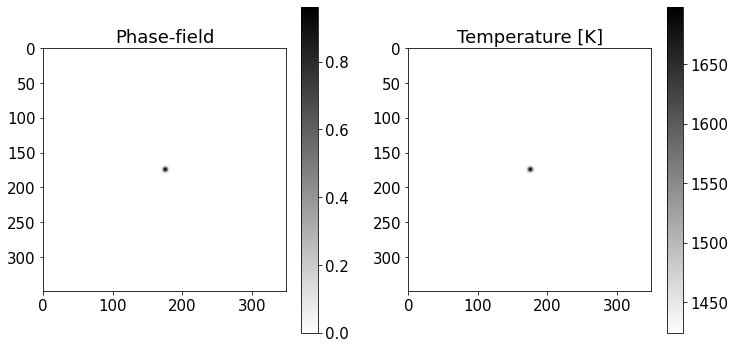

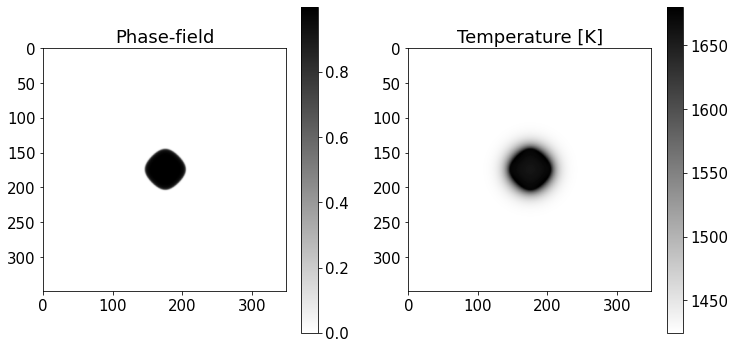

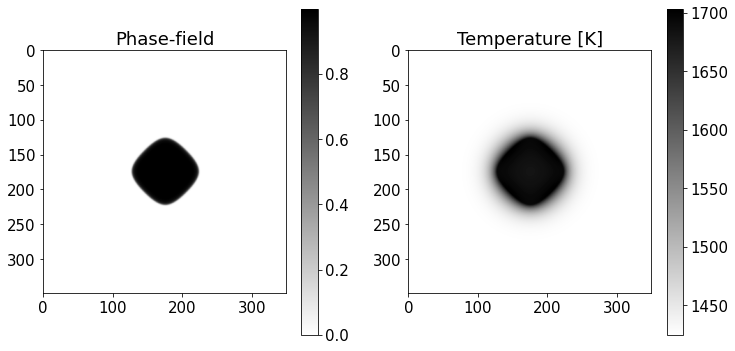

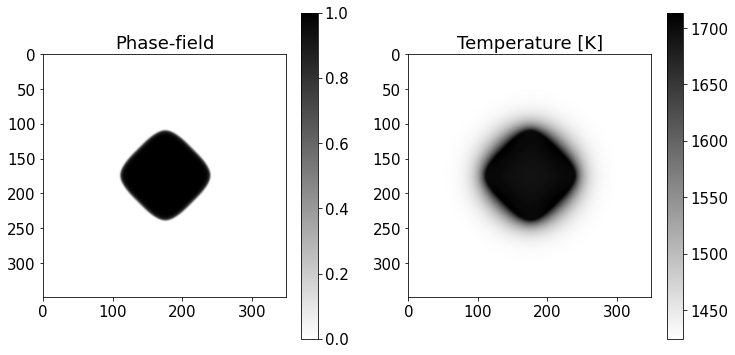

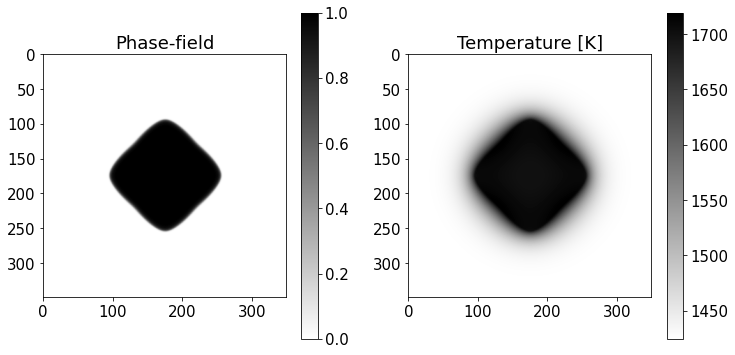

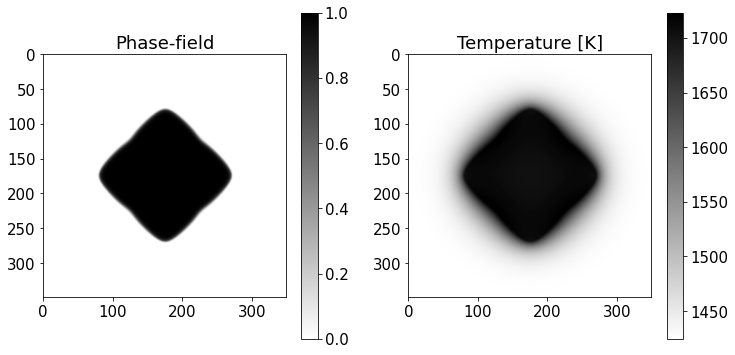

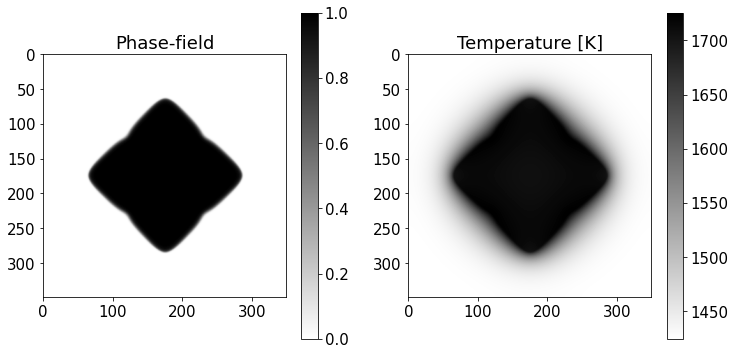

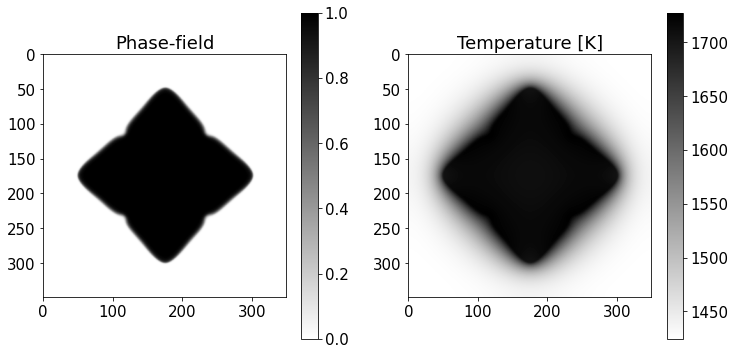

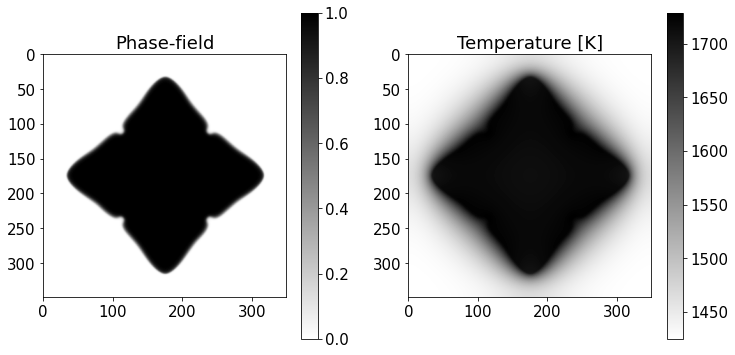

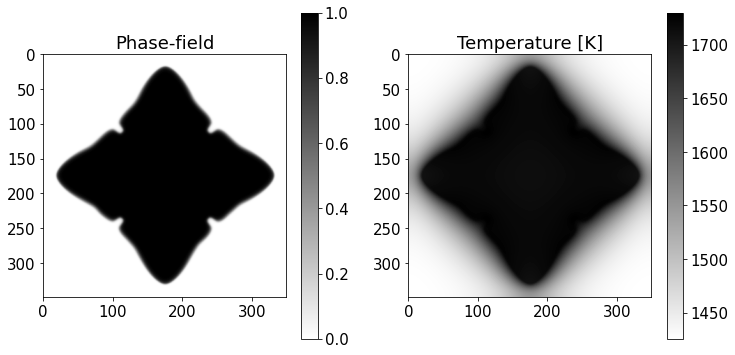

In [7]:
nstep = 0
for nstep in range(stepmax):
    calcgrad(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2)
    timeevol(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2,phi_new,temp_new)
    phi = phi_new
    temp = temp_new
    if (nstep % stepout) == 0:
      print("STEP=", nstep)
      plt.figure(figsize=(12,6))
      plt.rcParams["font.size"] = 15
      plt.subplot(121)
      plt.imshow(phi, cmap="binary")
      plt.title('Phase-field')
      plt.colorbar()
      plt.subplot(122)
      plt.imshow(temp, cmap="binary")
      plt.title('Temperature [K]')
      plt.colorbar()
      #plt.show()
      plt.savefig('result{}.pdf'.format(nstep), format="pdf", dpi=300)